In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle

In [2]:
def get_views_coord():

    """Get views data with coords"""

    path = '/home/polichinel/Documents/Articles/conflict_prediction/data/ViEWS/'
    file_name = 'ViEWS_coord.pkl'

    file_path = os.path.join(path, file_name)
    views_coord = pd.read_pickle(file_path)

    return(views_coord)

df = get_views_coord()

In [3]:
print(f"years from {df['year'].min()} to {df['year'].max()}. Shape: {df.shape}")

years from 1989 to 2018. Shape: (3843720, 18)


count    10677.000000
mean         0.999251
std          5.763137
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        187.000000
Name: ged_total_events_sb, dtype: float64


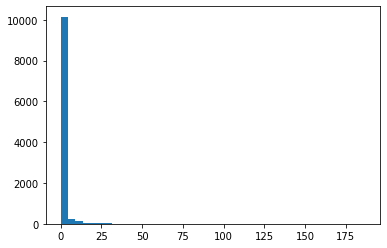

number of cells in sample givne C=5: 453


In [4]:
def get_conflict_gids(C=5, info = True):

    """Get gids (pg_ids) with conflicst. 
    C = the number of total monthly conflicts events experienced through the time line. 
    Defuelt C =5.
    If info = True describtion and as histogram of total_events will be printed/showed"""

    df_sb_total_events = df.groupby(['pg_id']).sum()['ged_dummy_sb'].reset_index().rename(columns = {'ged_dummy_sb':'ged_total_events_sb'})
    
    if info == True:
        
        print(df_sb_total_events['ged_total_events_sb'].describe())
        plt.hist(df_sb_total_events['ged_total_events_sb'], bins = 42)
        plt.show()

    conflict_gids = df_sb_total_events[df_sb_total_events['ged_total_events_sb'] > C]['pg_id']
    print(f'number of cells in sample givne C={C}: {conflict_gids.shape[0]}')

    return(conflict_gids)

conflict_gids = get_conflict_gids(C = 5)

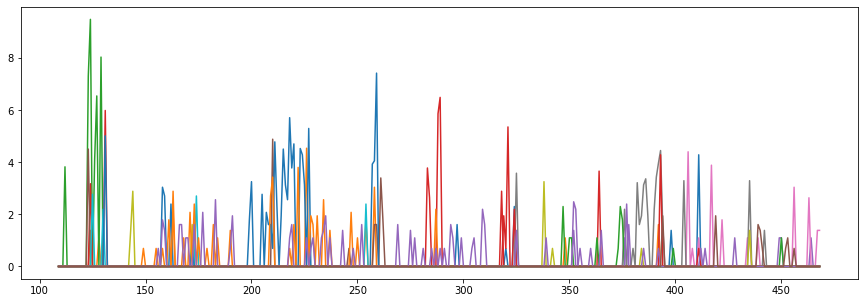

In [5]:
plt.figure(figsize= [15,5])

random_gids = conflict_gids.sample(16, random_state = 42).values
df_sorted = df.sort_values('month_id')

random_sub = df_sorted[df_sorted['pg_id'].isin(random_gids)] 

for i in random_gids:
    
    x = random_sub[random_sub['pg_id'] == i]['month_id']
    y = np.log(random_sub[random_sub['pg_id'] == i]['ged_best_sb'] +1)

    plt.plot(x, y)
plt.show()

## Run a small GP or two:
You should devide into train, validation (calibrate) and test allready

In [6]:
import pymc3 as pm
from sklearn.metrics import mean_squared_error
#import arviz as az # need trace for this, so wait until you have it running on computerome.
print(pm.__version__)

3.10.0


In [7]:
def test_val_train(df, info = True):

    """For train, validation and test. In accordance with Hegre et al. 2019 p. 163"""

    #jan 1990 = month_id 121 (12)
    #dec 2011 = month_id 384 (275)

    #jan 2012 = month_id 385 (276)
    #dec 2014 = month_id 420 (311)

    #jan 2015 = month_id 421 (312)
    #dec 2017 = month_id 456 (347)

    start = [12, 276, 312]
    end = [275, 311, 347]

    for i in range(3):

        jan = df['month_id'].unique()[start[i]]
        dec = df['month_id'].unique()[end[i]]

        month1 = df[df['month_id'] == jan][['year', 'month']]['month'].unique()
        year1 = df[df['month_id'] == jan][['year', 'month']]['year'].unique()

        month2 = df[df['month_id'] == dec][['year', 'month']]['month'].unique()
        year2 = df[df['month_id'] == dec][['year', 'month']]['year'].unique()

        if info == True:
            string = f'from: {month1[0]}/{year1[0]} to {month2[0]}/{year2[0]}\n'
            print(string)

    return(start, end)

start, end = test_val_train(df)

from: 1/1990 to 12/2011

from: 1/2012 to 12/2014

from: 1/2015 to 12/2017



In [8]:
def sample_conflict_timeline(df, C=5, N=3):

    """ This function samples N-time lines contining c>C conflicts"""

    # sort the df - just in case
    df_sorted = df.sort_values('month_id')

    # groupby gids and get total events
    df_sb_total_events = df.groupby(['pg_id']).sum()['ged_dummy_sb'].reset_index().rename(columns = {'ged_dummy_sb':'ged_total_events_sb'})
    # sample one gid from all gids from timeline with c>C events
    sample_gids = df_sb_total_events[df_sb_total_events['ged_total_events_sb'] > C]['pg_id'].sample(N, random_state = 666).values

    y = np.log(df_sorted[df_sorted['pg_id'].isin(sample_gids)]['ged_best_sb'] +1).values.reshape(-1,N)
    X = df_sorted[df_sorted['pg_id'].isin(sample_gids)]['month_id'].values.reshape(-1,N)


    return(X, y)


# One trend model:

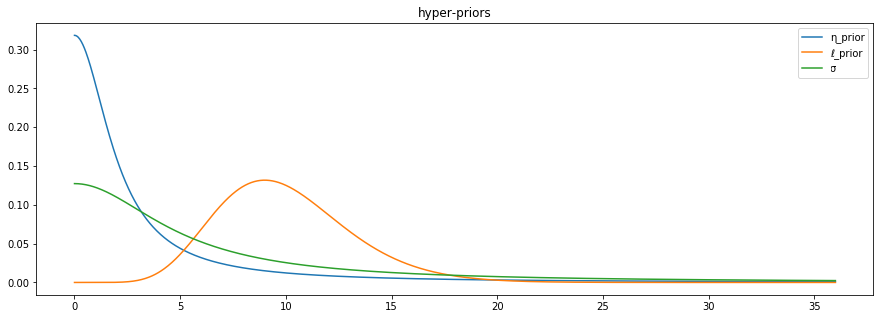

In [9]:
def get_priors(plot = True):

    η_beta = 2
    ℓ_beta = 1
    ℓ_alpha = 10
    σ_beta = 5

    grid = np.linspace(0,36,1000)
    
    priors = [
    ('η_prior', pm.HalfCauchy.dist(beta=η_beta, shape = 1)),
    ('ℓ_prior', pm.Gamma.dist(alpha=ℓ_alpha , beta=ℓ_beta, shape = 1)),
    ('σ', pm.HalfCauchy.dist(beta=σ_beta, shape = 1))]

    if plot == True:

        plt.figure(figsize= [15,5])
        plt.title('hyper-priors')

        for i, prior in enumerate(priors):
            plt.plot(grid, np.exp(prior[1].logp(grid).eval()), label = prior[0])

        plt.legend()
        plt.show()

    return(priors)

priors = get_priors()

In [15]:
#number of sampled timelines:
N = 5

# Priors
η_beta = 2
ℓ_beta = 1
ℓ_alpha = 10
σ_beta = 5

with pm.Model() as model:

    # trend
    ℓ = pm.Gamma("ℓ", alpha=ℓ_alpha , beta=ℓ_beta)
    η = pm.HalfCauchy("η", beta=η_beta)
    cov = η **2 * pm.gp.cov.ExpQuad(1, ℓ) # Cov func.

    # noise model
    σ = pm.HalfCauchy("σ", beta=σ_beta)

    # sample and split X,y    
    X, y = sample_conflict_timeline(df, C = 100, N=N)
    
    X_val = X[start[1]:end[1],:] # val 2012- 2015
    y_val = y[start[1]:end[1],:] # val 2012- 2015

    X = X[start[0]:end[0],:] # train 1990-2011
    y = y[start[0]:end[0],:] # train 1990-2011

    # mean func. (constant) 
    mean =  pm.gp.mean.Zero()# placeholder if you do individuel

    # GP
    gp = pm.gp.Marginal(mean_func = mean, cov_func=cov)

    # sample:

    for i in range(N):

        # gp.mean_func = pm.gp.mean.Constant(y[:,i].mean()) # individual mean_func
        y_ = gp.marginal_likelihood(f'y_{i}', X=X[:,i][:,None], y=y[:,i], noise= σ)
    
    mp = pm.find_MAP()


pd.DataFrame({
    "Parameter": ["ℓ", "η", "σ"],
    "Value at MAP": [float(mp["ℓ"]), float(mp["η"]), float(mp["σ"])]
    })

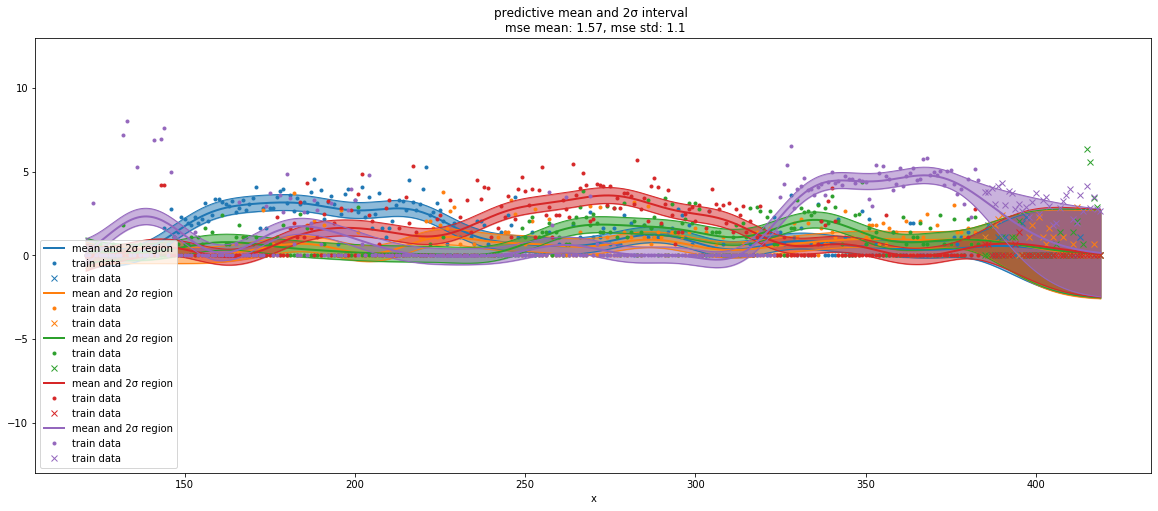

In [16]:
mse_list = []

# new values from X.min() to X.max() + 36
forecast_months = 36
X_new = np.linspace(X.min(), X.max() + forecast_months, (X.max() + forecast_months +1))[:, None]

# draw plot
fig = plt.figure(figsize=(20, 8))
ax = fig.gca()

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']

for i in range(N):

# predict mu and var
    # gp.mean_func = pm.gp.mean.Constant(y[:,i].mean()) # individual mean_func

    mu, var = gp.predict(X_new, 
    point=mp, 
    given = {'gp' : gp, 'X' : X[:,i][:,None], 'y' : y[:,i], 'noise' : σ}, 
    diag=True)
    
    sd = np.sqrt(var)

    # plot mean and 2σ intervals
    plt.plot(X_new, mu, "-", lw=2, color=colors[i], label="mean and 2σ region")
    plt.plot(X_new, mu + 2 * sd, "-", lw=1, color=colors[i])
    plt.plot(X_new, mu - 2 * sd, "-", lw=1, color=colors[i])
    plt.fill_between(X_new.flatten(), mu - 2 * sd, mu + 2 * sd, color=colors[i], alpha=0.5)

    # plot original data and true function
    plt.plot(X[:,i], y[:,i], "o", ms=3, color=colors[i], alpha=1.0, label="train data")
    plt.plot(X_val[:,i], y_val[:,i], "x", ms=6, color=colors[i], alpha=1.0, label="train data")

    # get mse
    true = y_val[:,i]
    pred = mu[start[1]:end[1]]
    mse_list.append(mean_squared_error(true, pred))

mse_mean = np.array(mse_list).mean()
mse_std = np.array(mse_list).std()

plt.xlabel("x")
plt.ylim([-13, 13])
plt.title(f"predictive mean and 2σ interval \n mse mean: {mse_mean:.3}, mse std: {mse_std:.3}")
plt.legend(loc=3)
plt.show()

## two trends model

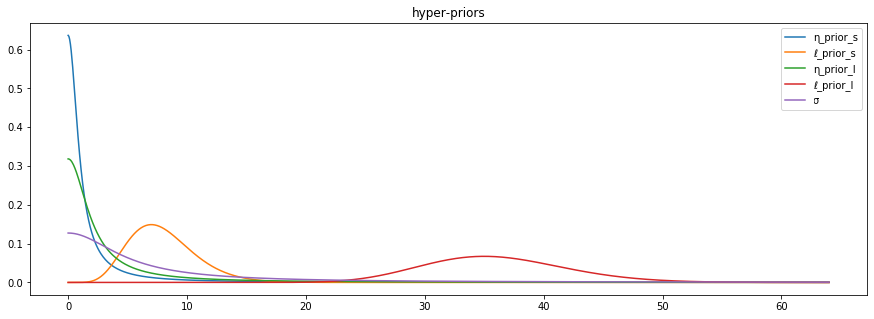

In [12]:
# short term priors
η_beta_s = 1
ℓ_beta_s = 1
ℓ_alpha_s = 8

# long term priors
η_beta_l = 2
ℓ_beta_l = 1
ℓ_alpha_l = 36

# nise prior
σ_beta = 5

grid = np.linspace(0,64,1000)
    
priors = [
    ('η_prior_s', pm.HalfCauchy.dist(beta=η_beta_s, shape = 1)),
    ('ℓ_prior_s', pm.Gamma.dist(alpha=ℓ_alpha_s , beta=ℓ_beta_s, shape = 1)),
    ('η_prior_l', pm.HalfCauchy.dist(beta=η_beta_l, shape = 1)),
    ('ℓ_prior_l', pm.Gamma.dist(alpha=ℓ_alpha_l , beta=ℓ_beta_l, shape = 1)),
    ('σ', pm.HalfCauchy.dist(beta=σ_beta, shape = 1))]

plt.figure(figsize= [15,5])
plt.title('hyper-priors')

for i, prior in enumerate(priors):
    plt.plot(grid, np.exp(prior[1].logp(grid).eval()), label = prior[0])

plt.legend()
plt.show()



In [47]:
#number of sampled timelines:
N = 5

with pm.Model() as model:

    # short term irregularities
    ℓ_s = pm.Gamma("ℓ_s", alpha=ℓ_alpha_s , beta=ℓ_beta_s)
    η_s = pm.HalfCauchy("η_s", beta=η_beta_s)
    
    mean_s =  pm.gp.mean.Zero()
    #cov_s = η_s **2 * pm.gp.cov.ExpQuad(1, ℓ_s) # Cov func.

    α_s = pm.Gamma("α", alpha=5, beta=2)
    cov_s = η_s ** 2 * pm.gp.cov.RatQuad(1, ℓ_s, α_s) # this seems to help alot when you split the trends below

    gp_s = pm.gp.Marginal(mean_func = mean_s, cov_func=cov_s)

    # long term trend
    ℓ_l = pm.Gamma("ℓ_l", alpha=ℓ_alpha_l , beta=ℓ_beta_l)
    η_l = pm.HalfCauchy("η_l", beta=η_beta_l)
    
    mean_l =  pm.gp.mean.Zero()
    cov_l = η_l **2 * pm.gp.cov.ExpQuad(1, ℓ_l) # Cov func.

    gp_l = pm.gp.Marginal(mean_func = mean_l, cov_func=cov_l)

    # noise model
    σ = pm.HalfCauchy("σ", beta=σ_beta)

    # sample and split X,y    
    X, y = sample_conflict_timeline(df, C = 100, N=N)
    
    X_val = X[start[1]:end[1],:] # val 2012- 2015
    y_val = y[start[1]:end[1],:] # val 2012- 2015

    X = X[start[0]:end[0],:] # train 1990-2011
    y = y[start[0]:end[0],:] # train 1990-2011

    # GP
    gp = gp_s + gp_l

    # sample:
    for i in range(N):

        #gp.mean_func = pm.gp.mean.Constant(y[:,i].mean()) # individual mean_func
        y_ = gp.marginal_likelihood(f'y_{i}', X=X[:,i][:,None], y=y[:,i], noise= σ)
    
    mp = pm.find_MAP()


pd.DataFrame(
    {
        "Parameter": ["ℓ_s", "η_s", "α_s", "ℓ_l", "η_l", "σ"],
        "Value at MAP": [float(mp["ℓ_s"]), float(mp["η_s"]), float(mp["ℓ_l"]), float(mp["η_l"]), float(mp["σ"])],
    }
)

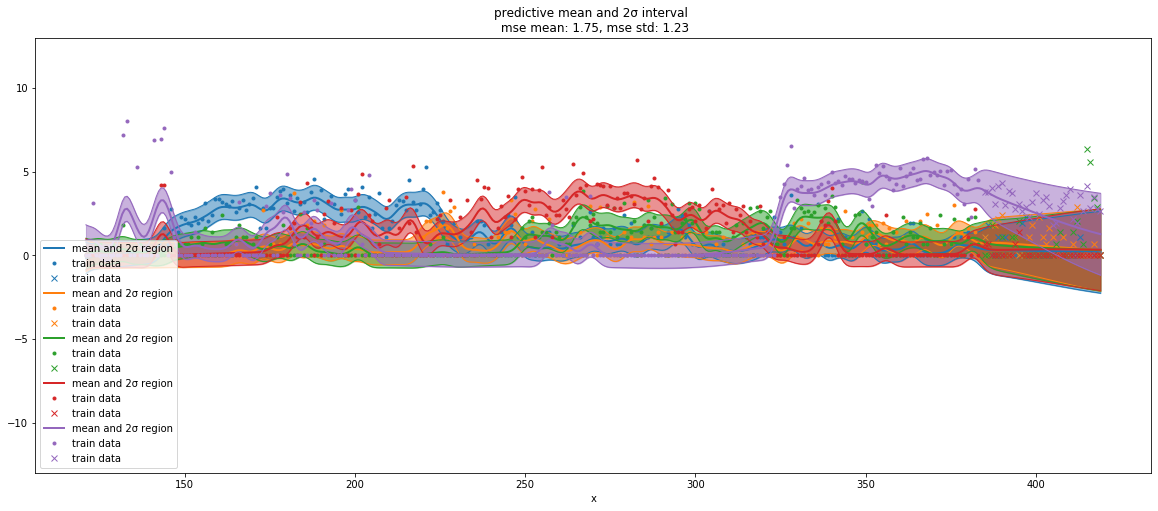

In [48]:
mse_list = []

# new values from X.min() to X.max() + 36
forecast_months = 36
X_new = np.linspace(X.min(), X.max() + forecast_months, (X.max() + forecast_months +1))[:, None]

# draw plot
fig = plt.figure(figsize=(20, 8))
ax = fig.gca()

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']

for i in range(N):

# predict mu and var
    #gp.mean_func = pm.gp.mean.Constant(y[:,i].mean()) # individual mean_func

    mu, var = gp.predict(X_new, 
    point=mp, 
    given = {'gp' : gp, 'X' : X[:,i][:,None], 'y' : y[:,i], 'noise' : σ}, 
    diag=True)
    
    sd = np.sqrt(var)

    # plot mean and 2σ intervals
    plt.plot(X_new, mu, "-", lw=2, color=colors[i], label="mean and 2σ region")
    plt.plot(X_new, mu + 2 * sd, "-", lw=1, color=colors[i])
    plt.plot(X_new, mu - 2 * sd, "-", lw=1, color=colors[i])
    plt.fill_between(X_new.flatten(), mu - 2 * sd, mu + 2 * sd, color=colors[i], alpha=0.5)

    # plot original data and true function
    plt.plot(X[:,i], y[:,i], "o", ms=3, color=colors[i], alpha=1.0, label="train data")
    plt.plot(X_val[:,i], y_val[:,i], "x", ms=6, color=colors[i], alpha=1.0, label="train data")

    # get mse
    true = y_val[:,i]
    pred = mu[start[1]:end[1]]
    mse_list.append(mean_squared_error(true, pred))

mse_mean = np.array(mse_list).mean()
mse_std = np.array(mse_list).std()

plt.xlabel("x")
plt.ylim([-13, 13])
plt.title(f"predictive mean and 2σ interval \n mse mean: {mse_mean:.3}, mse std: {mse_std:.3}")
plt.legend(loc=3)
plt.show()

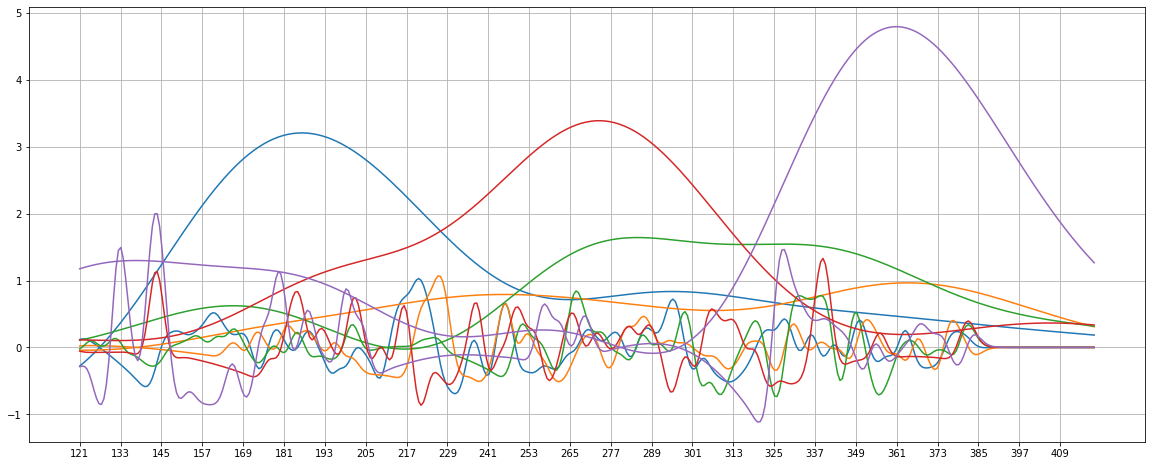

In [52]:
fig = plt.figure(figsize=(20, 8))

for i in range(N):

    mu_s, var_s = gp_s.predict(X_new, 
    point=mp, 
    given = {'gp' : gp, 'X' : X[:,i][:,None], 'y' : y[:,i], 'noise' : σ}, 
    diag=True)

    mu_l, var_l = gp_l.predict(X_new, 
    point=mp, 
    given = {'gp' : gp, 'X' : X[:,i][:,None], 'y' : y[:,i], 'noise' : σ}, 
    diag=True)

    plt.plot(X_new, mu_s, label = 'predicted f_short', color = colors[i])
    plt.plot(X_new, mu_l, label = 'predicted f_long', color = colors[i])

#plt.vlines(32,-1,1, linestyles= 'dashed', color = 'gray')

plt.xticks(np.arange(X_new.min(),X_new.max(), 12))
plt.grid()
#plt.legend()
plt.show()

In [ ]:
with model:
    trace = pm.sample()

In [ ]:
pm.traceplot(trace, varnames=['η_s', 'ℓ_s','η_l', 'ℓ_l', 'σ'])
plt.show()

In [ ]:
pm.summary(trace)

# more elaborate but a bit beside the point here - tho the posterio predictive dies call your bluff..

In [129]:
# new values from x.min() to x.max() + 36
X_new = np.linspace(x.min(), x.max() + 36, (x.max() + 36 +1))[:, None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_posterior_predictive([mp], vars=[f_pred], samples=2000)

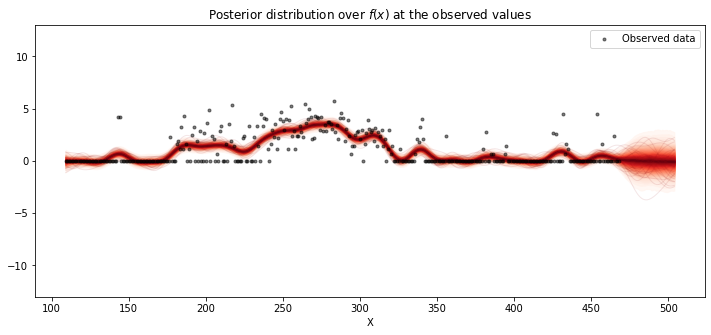

In [130]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, pred_samples["f_pred"], X_new)

# plot the data and the true latent function
plt.plot(x, y, "ok", ms=3, alpha=0.5, label="Observed data")

# axis labels and title
plt.xlabel("X")
plt.ylim([-13, 13])
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend()
plt.show()

In [131]:
# Draw from the posterior predictive distribution
with model:
    y_pred = gp.conditional("y_pred", X_new, pred_noise=True)
    y_samples = pm.sample_posterior_predictive([mp], vars=[y_pred], samples=2000)

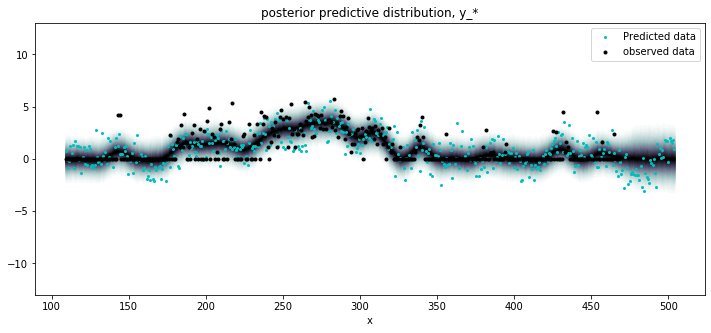

In [133]:
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# posterior predictive distribution
plot_gp_dist(ax, y_samples["y_pred"], X_new, plot_samples=False, palette="bone_r")

# overlay a scatter of one draw of random points from the
#   posterior predictive distribution
plt.plot(X_new, y_samples["y_pred"][800, :].T, "co", ms=2, label="Predicted data")

# plot original data and true function
plt.plot(X, y, "ok", ms=3, alpha=1.0, label="observed data")

plt.xlabel("x")
plt.ylim([-13, 13])
plt.title("posterior predictive distribution, y_*")
plt.legend()
plt.show()

In [134]:
# predict
mu, var = gp.predict(X_new, point=mp, diag=True)
sd = np.sqrt(var)


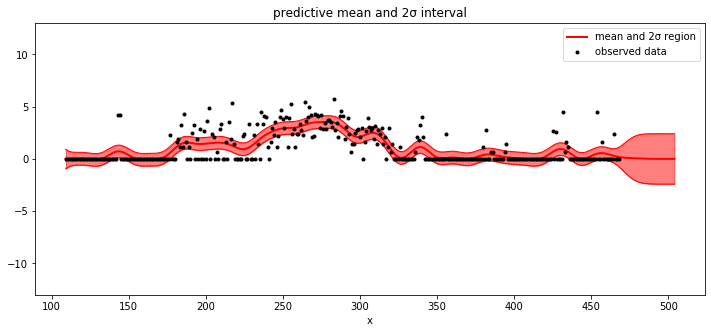

In [135]:

# draw plot
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot mean and 2σ intervals
plt.plot(X_new, mu, "r", lw=2, label="mean and 2σ region")
plt.plot(X_new, mu + 2 * sd, "r", lw=1)
plt.plot(X_new, mu - 2 * sd, "r", lw=1)
plt.fill_between(X_new.flatten(), mu - 2 * sd, mu + 2 * sd, color="r", alpha=0.5)

# plot original data and true function
plt.plot(X, y, "ok", ms=3, alpha=1.0, label="observed data")

plt.xlabel("x")
plt.ylim([-13, 13])
plt.title("predictive mean and 2σ interval")
plt.legend()
plt.show()